# Comparing Bitcoin investment strategies

## Disclaimer

First and foremost, it must be said (once again) that **past performance is not indicative of future results**. This article is about evaluating and understanding performance of strategies from an arbitrary point of time in the past until today. Basing your financial decisions solely on this source would be, at best, irresponsible. If you are just looking to get rich quick, buying lottery tickets may be more effective and yield more predictive result than trying to understand Bitcoin.

That being said, we can now continue with our research. Strap in and enjoy :)

## Introduction

Every time price of BTC goes up, there is an influx of new users who ask for investment advice, and you can be sure that the debate over Lump Sum or Dollar Cost Averaging pops up.  There are many sources claiming Lump Sum is a better investment strategy ([Vanguard](https://static.twentyoverten.com/5980d16bbfb1c93238ad9c24/rJpQmY8o7/Dollar-Cost-Averaging-Just-Means-Taking-Risk-Later-Vanguard.pdf) or [Leggio, Lien](https://link.springer.com/article/10.1007/BF02827219) ) but all of this research is done based on traditional assets (SPY or similar). 

Outside of these studies, there are also many believers in one or other strategy, that will push it without any data to back it up. Worse, sometimes they pick precisely the data that matches their result (buying at the extremes). When evaluating any investment strategy, it is important to look at the strategy overall and not at a particular point of time, which may never happen again.

What we can do objectively, is to remove emotions from the game by looking at raw numbers. This article will primarily concentrate on this aspect of investing and decision making.

### Mentions
While browsing through possibilities on how to realize this project, I came upon [a study that does exactly what I needed](https://github.com/Elucidation/lumpsum_vs_dca), but is based on S&P 500 index. This work sparked my interest and showed me how to properly evaluate and publish the data for Bitcoin. What follows is heavily based on this original. Same as the original, this work is published under the Apache 2.0 license. You can inspect and reuse [the source code on Github]()

### TL;DR
We created a simple trial comparing lump sum to the strategy of investing in the same amount monthly over a year, and found that lump sum still won ~67.9% of the time. Even the arbitrarily reduced dataset (post $100 per BTC era) showed that Lump Sum beats DCA 60.8% of time, and provides double the gains on average.


## Definition of our problem

Aim of this article is to evaluate two different strategies of investing FIAT currency into Bitcoin, and calculate their performance based on historical movement of Bitcoin/USD exchange rate.

Let's imagine we have \\$10,000 to invest any time in the last 9 years, from 2010-07-19 to 2019-10-11. We want to choose the time and strategy that would have returned us the most money today. The two strategies I chose are:

1. **Lump Sum**, we invest our available funds all at one
2. **Dollar cost average (DCA)**, we divide our available funds into 12 equal portions, and invest them every month starting from the chosen date.

## Assumptions
Throughout the study we will work with following assumptions
1. We concentrate on Bitcoin only. We do not take any forks or derivate products into account. (this has minimal effects on our study.)
2. At any point in time, we have \\$10,000 to invest as a Lump Sum. 
3. We do not take price of money, opportunity costs or inflation into account. (This would marginally favor Lump Sum)
4. Our investment value is based on the closing price of any given period.
5. We do not take any commissions or transaction related fees into account. (This would marginally favor Lump Sum)
6. We omit any 'personal' value Bitcoin may represent to you.


## Importing financial data using Pandas

First, we have to initialize our workspace and find a suitable dataset to base our study on.
* Data from 2010-07-18 to 2013-10-05 is taken from https://coinmetrics.io/data-downloads/ , source for this period is sadly unknown (MtGox maybe? since they did launch in July 2010)
* Data from 2013-10-06 onwards is taken from Kraken BTCUSD exchange pair, downloaded from http://www.cryptodatadownload.com/data/northamerican/

We will be importing the data using [Pandas](https://pandas.pydata.org/), a great python library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language. We will use it together with [matplotlib](https://matplotlib.org/3.1.0/index.html), a python 2D plotting library that is Matlab flavored. Supporting calculations will be done by [Numpy](https://numpy.org/), fundamental package for scientific computing with Python.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib import style

# Basic styling
style.use('seaborn-notebook')
pd.set_option('display.width', 200)

# load data
btc = pd.read_csv("../data/btcusd.csv")

# Index dataset by date
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.set_index('Date')
btc = btc.sort_index()

# resample dataset from days to months
btc_monthly = btc.resample('M').ffill()

# print results
print(btc.tail())
print(btc_monthly.tail())


             Close
Date              
2019-10-04  8152.2
2019-10-05  8148.4
2019-10-06  7863.0
2019-10-07  8213.4
2019-10-08  8210.3
              Close
Date               
2019-06-30  10752.3
2019-07-31  10090.1
2019-08-31   9604.3
2019-09-30   8310.0
2019-10-31   8210.3


We have created 2 datasets. One containing daily Bitcoin history, another one reduced to show only last day of each month.   We can plot this data using matplotlib and do a first visual inspection of price changes over time. 

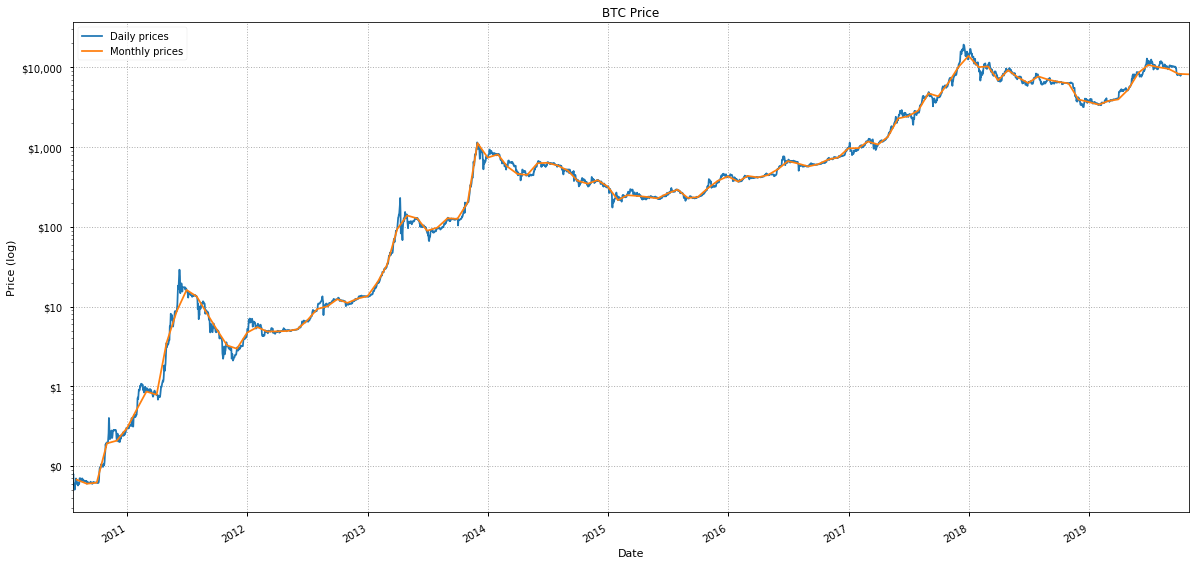

In [14]:
ax = plt.subplot()

btc['Close'].plot(figsize=(20,10),ax=ax)
btc_monthly['Close'].plot(ax=ax)

ax.set_yscale('log')
plt.grid(linestyle='dotted')

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}'.format(x))) # Y axis dollarsymbols
plt.xlabel("Date")
plt.ylabel("Price (log)")
plt.title("BTC Price")
ax.legend(["Daily prices", "Monthly prices"])

plt.show()


We will be plotting our charts are on logarithmic scale. This is just to illustrate, that a jump from \\$10 to \\$100 is the same as a jump from \\$100 to \\$1000 and the same as a jump from \\$1000 to \\$10000 when it comes to investing. In all 3 cases, your investment gained 10 times its value.

We can identify past bubbles (mid 2011, Dec 2014 and Dec 2018) as well as the dips that followed. 

Another observation we can make from this graph, is that monthly dataset is a bit "smoother". This is to be expected, especially when working with an unstable underlying asset. 

If you look for an answer on how volatile Bitcoin is, stay tuned, this will be analysed ina future article. For now, since we are not evaluating day trading strategies and are only concerned with investments at predefined time periods, we can omit these daily swings and just work with monthly closing prices. Daily data may be needed in the future, if we decide to work with different investment strategies.

## Calculating value of Lump sum investment

Lump Sum means to invest everything available all at once, in this case we have a hypothetical \\$10,000 to spend at any month in our history of the last 9 years. Then we want to know how much that investment would be worth today.

Another way to look at this is we can make a chart where the X axis is the date we invest the lump sum, and the Y axis is the value of that investment today.

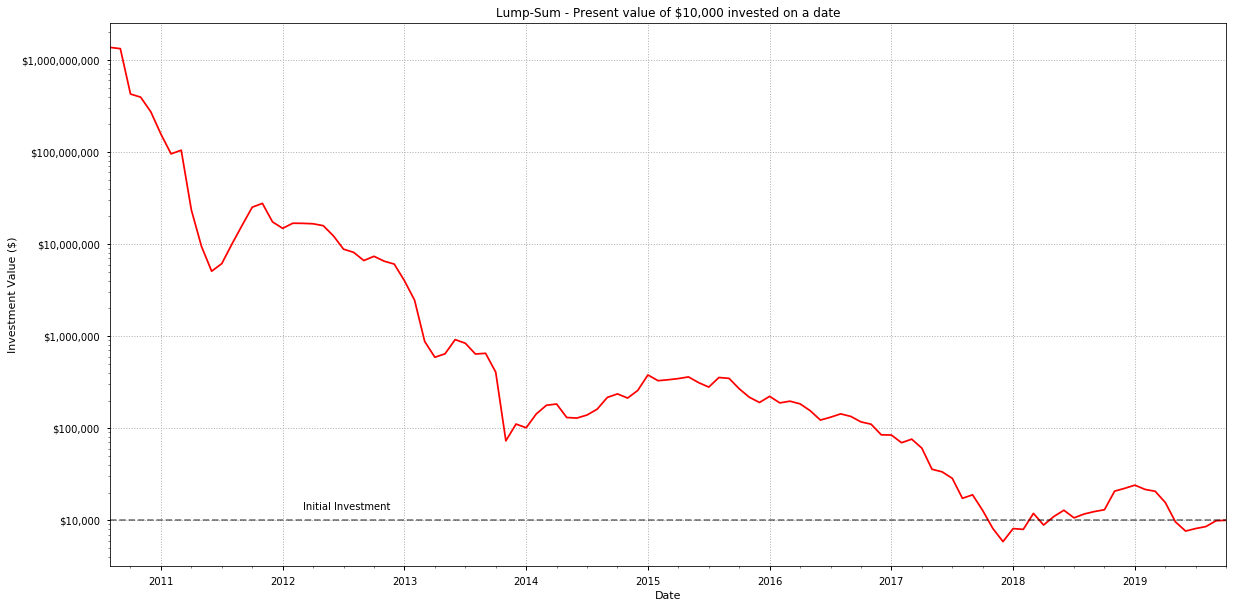

In [15]:
value_price = btc_monthly['Close'][-1]
initial_investment = 10000.00

num_btc_bought = initial_investment / btc_monthly['Close']
lumpsum = num_btc_bought * value_price
lumpsum.name = 'Lump Sum'


# fig2 = plt.figure(2)
ax = plt.subplot()
# ax = fig2.add_subplot(222)
lumpsum[1:].plot(ax=ax, figsize=(20,10), color='r', label="Lump-Sum")

ax.set_yscale('log')
plt.grid(linestyle='dotted')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))

ax.axhline(initial_investment, alpha=0.5, linestyle="--", color="black")
ax.text(btc_monthly.index[20],initial_investment*1.3, "Initial Investment")
plt.title('Lump-Sum - Present value of $10,000 invested on a date')
plt.ylabel('Investment Value ($)')
plt.show()


Getting in early is definitely a good strategy :) if only we knew! This graph shows why so many sources and seasoned investors prefer Lump Sum investing. The sooner we put our money in, the more we can potentially gain. 

Let's have a closer look at some extremes.

In [16]:
recenttime = 36 #number of months to look into past
print("Lump sum: Investing on the 1 - Best day, 2 - Worst day in past, 3 - Worst day in all")
print("1 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(lumpsum.idxmax().strftime('%b %d, %Y'), lumpsum.max()))
print("2 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(lumpsum[:-recenttime].idxmin().strftime('%b %d, %Y'), lumpsum[:-recenttime].min()))
print("3 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(lumpsum.idxmin().strftime('%b %d, %Y'), lumpsum.min()))

Lump sum: Investing on the 1 - Best day, 2 - Worst day in past, 3 - Worst day in all
1 - Investing $10,000 on Aug 31, 2010 would be worth $1,368,383,333.33 today.
2 - Investing $10,000 on Nov 30, 2013 would be worth $72,952.56 today.
3 - Investing $10,000 on Dec 31, 2017 would be worth $5,868.69 today.


As expected, the worst time to buy in would be on the 2017 bubble, this would cut our savings by 42%. Good thing is, that buying on any previous one, we would still be in positive numbers. Getting in just before the 2013 bubble popped and hodling, would make us over \\$70,000 today, not bad for 6 years of waiting.

## Calculating value of Dollar Cost Averaged investment
Dollar Cost Averaging (DCA) assumes that we want to minimize downside risk (buying the bubble). In order to do this, we do not invest the Lump Sum available to us all at once, but instead split it into multiple portions.

For our basic strategy, we will look into splitting our investment of \\$10,000 into 12 equal portions, and we invest these during 12 consecutive months. A special case is investing within the last year, when there isn't time to DCA all of it. As a compromise, We invest what portions We can and keep the rest as cash, since that is how reality works.

Please note, that there are many more strategies and possibilities to do DCA, but we will stick to this one (for now).

In [17]:
def doDCA(investment, start_date):
    # Get 12 investment dates in 30 day increments starting from start date
    investment_dates_all = pd.date_range(start_date,periods=12,freq='1M')
    # Remove those dates beyond our known data range
    investment_dates = investment_dates_all[investment_dates_all < btc_monthly.index[-1]]

    # Get closest business dates with available data
    closest_investment_dates = btc.index.searchsorted(investment_dates)

    # How much to invest on each date
    portion = investment/12.0 # (Python 3.0 does implicit double conversion, Python 2.7 does not)

    # Get the total of all stocks purchased for each of those dates (on the Close)
    stocks_invested = sum(portion / btc_monthly['Close'][investment_dates])

    # Add uninvested amount back
    uninvested_dollars = portion * sum(investment_dates_all >= btc_monthly.index[-1])

    # value of stocks today
    total_value = value_price*stocks_invested + uninvested_dollars
    return total_value

# Generate DCA series for every possible date
dca = pd.Series(btc_monthly.index.map(lambda x: doDCA(initial_investment, x)), index=btc_monthly.index, name='Dollar Cost Averaging (DCA)')

Surprisingly straightforward, good job Pandas. Let's plot it similar to how we did with lump sum. The x axis is the date at which we start dollar cost averaging (and then continue for the next 12 months in monthly increments from that date). The y axis is the final value of our investment today.

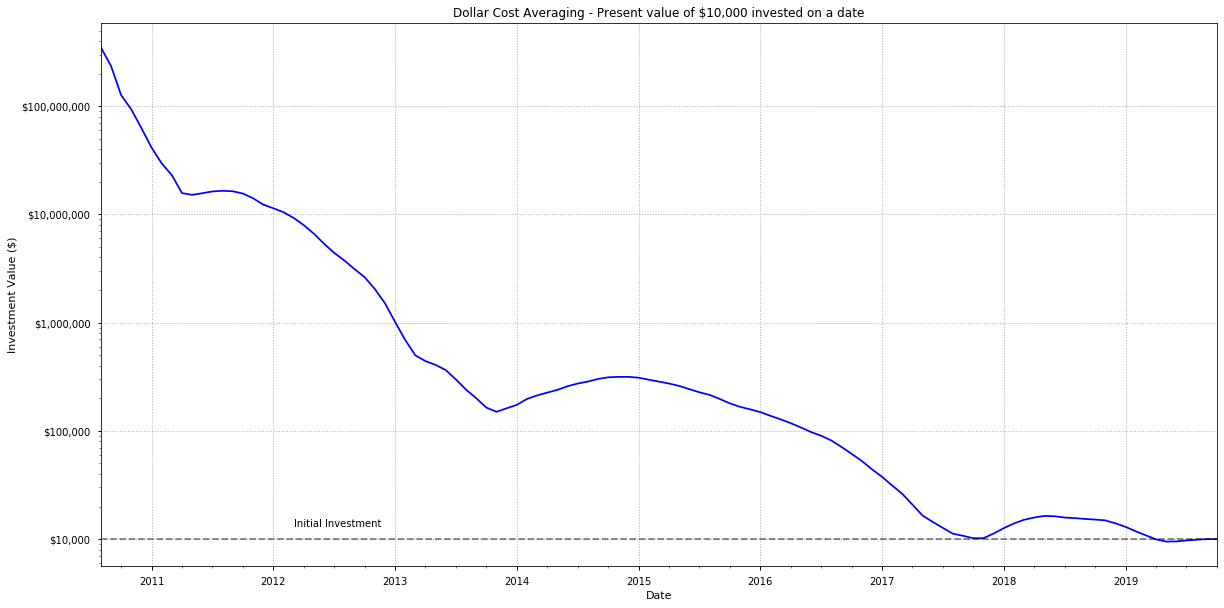

In [18]:
ax = plt.subplot()
dca[1:].plot(ax=ax, figsize=(20,10), color='b', label="DCA")

ax.set_yscale('log')
plt.grid(linestyle='dotted')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))

ax.axhline(initial_investment, alpha=0.5, linestyle="--", color="black")
ax.text(btc_monthly.index[20],initial_investment*1.3, "Initial Investment")
plt.title('Dollar Cost Averaging - Present value of $10,000 invested on a date')
plt.ylabel('Investment Value ($)')
plt.show()

Interesting! DCA looks way really smooth and the graph is really high up, so it must be better right!? Wait, no, the Y axis is different, in fact it's highest high is one order of magnitude lower in comparison to the Lump Sum. Let's look at the ideal/worst investment dates for DCA, I include the lump sum from before as well.

In [19]:
print("Lump sum: Investing on the 1 - Best day, 2 - Worst day in past, 3 - Worst day in all")
print("1 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(lumpsum.idxmax().strftime('%b %d, %Y'), lumpsum.max()))
print("2 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(lumpsum[:-recenttime].idxmin().strftime('%b %d, %Y'), lumpsum[:-recenttime].min()))
print("3 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(lumpsum.idxmin().strftime('%b %d, %Y'), lumpsum.min()))

print("DCA: Investing on the 1 - Best day, 2 - Worst day in past, 3 - Worst day in all")
print("1 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(dca.idxmax().strftime('%b %d, %Y'), dca.max()))
print("2 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(dca[:-recenttime].idxmin().strftime('%b %d, %Y'), dca[:-recenttime].min()))
print("3 - Investing $10,000 on {} would be worth ${:,.2f} today.".format(dca.idxmin().strftime('%b %d, %Y'), dca.min()))

Lump sum: Investing on the 1 - Best day, 2 - Worst day in past, 3 - Worst day in all
1 - Investing $10,000 on Aug 31, 2010 would be worth $1,368,383,333.33 today.
2 - Investing $10,000 on Nov 30, 2013 would be worth $72,952.56 today.
3 - Investing $10,000 on Dec 31, 2017 would be worth $5,868.69 today.
DCA: Investing on the 1 - Best day, 2 - Worst day in past, 3 - Worst day in all
1 - Investing $10,000 on Jul 31, 2010 would be worth $450,002,394.99 today.
2 - Investing $10,000 on Oct 31, 2016 would be worth $61,449.81 today.
3 - Investing $10,000 on May 31, 2019 would be worth $9,483.41 today.


Looking at DCA, best day to start would be one month earlier compared to Lump Sum - July of 2010. Its worst performance is not a tall related to the crash of 2017, but rather very recent - May 2019. This is to be expected, since extreme ups and downs are smoothed out by this strategy.

We can already see that there's some similarities between lump sum and DCA, DCA appears to have lower highs, but also higher lows. It's difficult to compare just by looking at numbers, we need to compare the two strategies visually side by side.

## Comparison of Lump Sum vs Dollar Cost Averaging

In order to conclude our research, we can plot a combined graph showing
* Bitcoin price evolution
* Above comparison of Lump Sum vs DCA investment strategies
* Difference between these 2 strategies for any given month

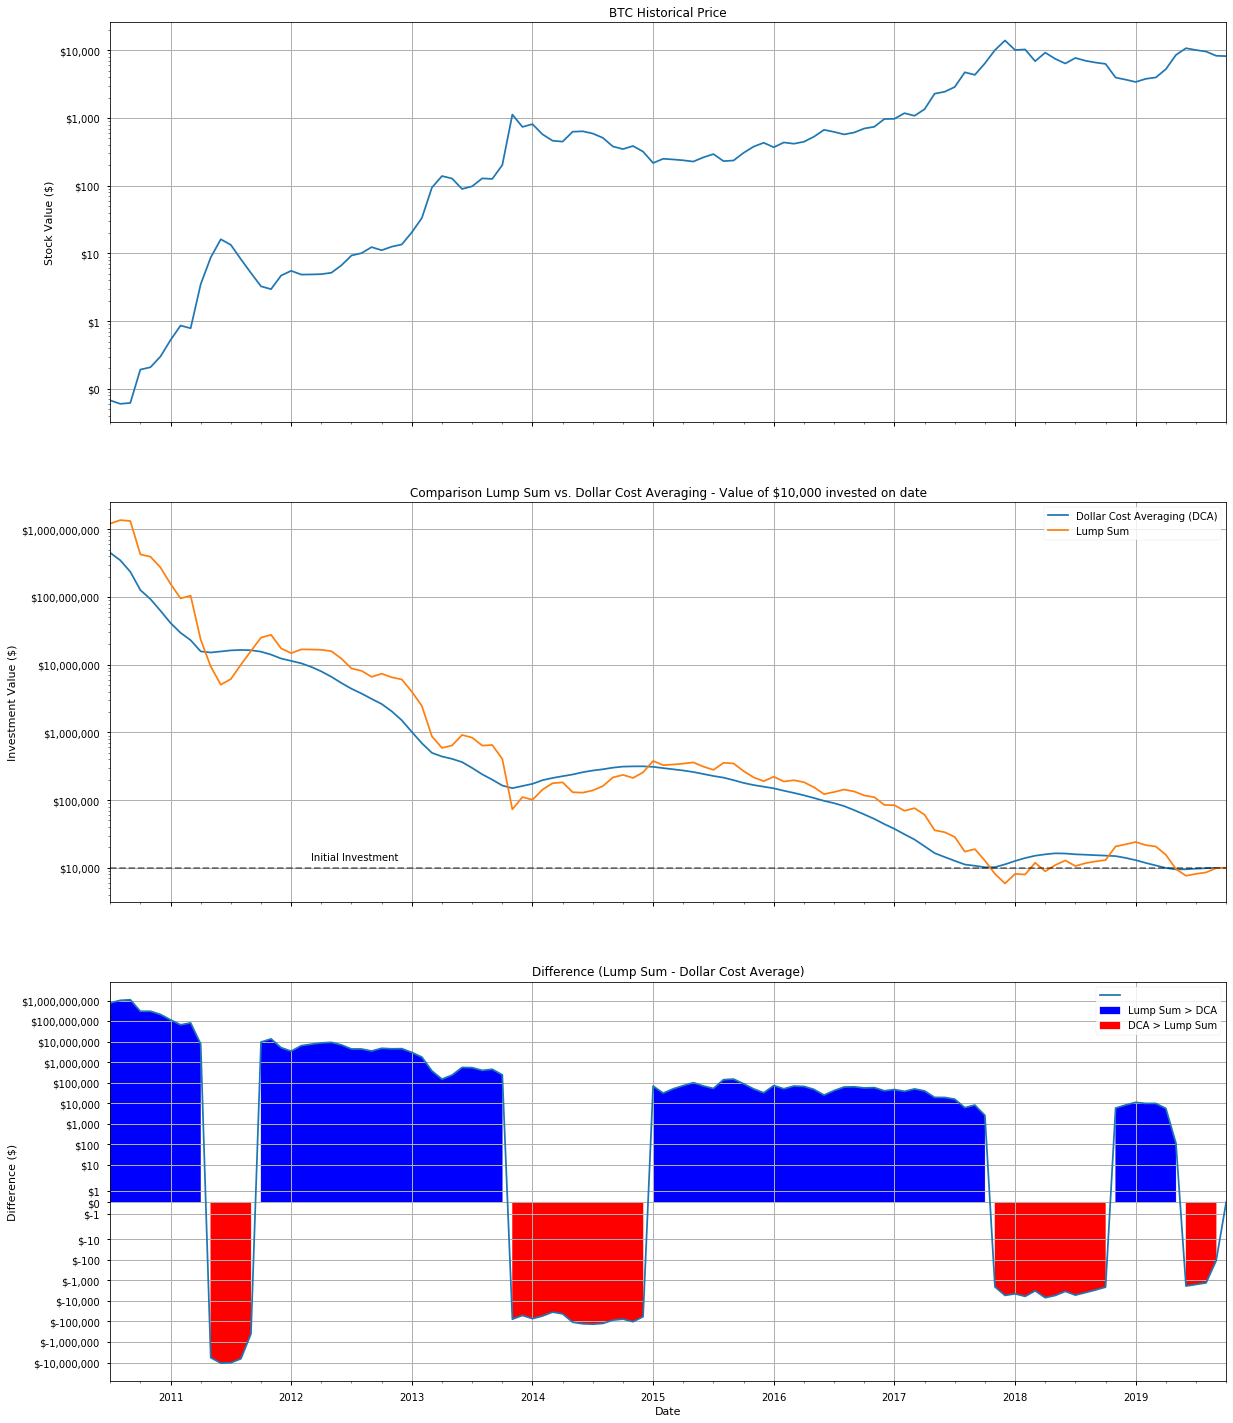

In [20]:
# Difference between lump sum and DCA
diff = (lumpsum - dca)
diff.name = 'Difference (Lump Sum - DCA)'

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,25), sharex=True)

# BTC Actual
btc_monthly['Close'].plot(ax=ax1)
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))
ax1.set_xlabel('')
ax1.set_title('BTC Historical Price')
ax1.set_ylabel('Stock Value ($)')
ax1.grid(True)

# Comparison
dca.plot(ax=ax2)
lumpsum.plot(ax=ax2)
ax2.axhline(initial_investment, alpha=0.5, linestyle="--", color="black")
ax2.text(btc_monthly.index[20],initial_investment*1.3, "Initial Investment")
ax2.grid(True)

ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))
ax2.legend()
ax2.set_title('Comparison Lump Sum vs. Dollar Cost Averaging - Value of $10,000 invested on date')
ax2.set_ylabel('Investment Value ($)')

# Difference
diff.plot(ax=ax3)
ax3.fill_between(diff.index, y1=diff, y2=0, color='blue', where=diff>0)
ax3.fill_between(diff.index, y1=diff, y2=0, color='red', where=diff<0)
ax3.grid(True)

ax3.set_yscale('symlog')
ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}'.format(x))) 
ax3.set_ylabel('Difference ($)')
ax3.set_title('Difference (Lump Sum - Dollar Cost Average)')
ax3.legend(["", "Lump Sum > DCA", "DCA > Lump Sum"])

plt.show()

## Statistics
Before we start comparing, definitely take note of the middle chart, where the initial investment of \\$10k is. Notice that if we had invested using either strategy, and at any point before 2 years ago, no matter which bubble or crash, we'd have made some pretty huge returns on our investments.

Looking at the DCA curve we do see the 4 similar humps we saw with the lump sum, but is both smoother and lags behind it. This makes perfect sense, as we're taking a type of moving average of Bitcoin price over a year (in monthly increments) when we buy, instead of a single date.

As a result our investment with DCA is less volatile (smoother), and lags behind (averages in previous investments) the lump sum values.

The line for difference shows a positive dollar value for how much more investing in one lump sum would return versus dollar cost averaging in (blue). Similarly, a negative value shows how much more dollar cost averaging would return vs a lump sum (red). The chart shows a wide swing mid-2011, around 2014 and in 2018 between the two strategies, but elsewhere it's mostly positive (blue), suggesting lump sum tends to return a bit more overall. Let's look at the actual percentage where the values are positive (where lump sum returns more).

In [21]:
print("Lump sum returns more than DCA %.1f%% of all the days" % (100*sum(diff>0)/len(diff)))
print("DCA returns more than Lump sum %.1f%% of all the days" % (100*sum(diff<0)/len(diff)))

Lump sum returns more than DCA 67.9% of all the days
DCA returns more than Lump sum 31.2% of all the days


Surprisingly, we arrive to the same conclusion as it is on traditional markets. 67.9% of the time, Lump Sum results in a higher final investment value over our monthly dollar cost averaging strategy. 

But maybe this isn't the whole story, perhaps the lump sum returned a little better than DCA most of the time, but in the really bad times DCA would do much better?

One way to look at this, would be to see the average amount improvement lump sum has when it is better, versus the average amount DCA improves, when it is better.

In [22]:
print("Mean difference: Average dollar improvement lump sum returns vs. dca: ${:,.2f}".format(sum(diff) / len(diff)))
print("Mean difference when lump sum > dca: ${:,.2f}".format(sum(diff[diff>0]) / sum(diff>0)))
print("Mean difference when dca > lump sum: ${:,.2f}".format(sum(-diff[diff<0]) / sum(diff<0)))

Mean difference: Average dollar improvement lump sum returns vs. dca: $35,973,766.53
Mean difference when lump sum > dca: $53,469,807.83
Mean difference when dca > lump sum: $989,815.53


So, for every possible day in the last 9 years, a lump sum investment of \\$10,000 would have returned on average \\$35 million(!) more than dollar cost averaging, I doubt there is an equivalent of this that exists on traditional markets (this may be an idea for a future article). However, when lump sum is better, it returned about \\$53 million more. Conversely, when dollar cost averaging was better than lump sum, it returned only \\$1 million more on average.

Since this is really extreme, I will make an exception and look at more recent dataset. 

In [23]:
first_100_day = (btc_monthly['Close'] >= 100).idxmax()
print(first_100_day)

2013-04-30 00:00:00


Above function finds first occurrence  of Bitcoin hitting value of \\$100. This effectively removes all the massive gains one could have when getting in during the first months of Bitcoins existence. It is also questionable, it there was enough market cap to actually invest $10,000 in those early days (pre $1-era at least), and if there was, what effect would such an investment have. Market cap will be most probably be studied in another article in the future.

Please note, that we do this to show the difference between our investment strategies on a more realistic scale, any manipulation of the dataset in this manner is very dangerous and can lead to [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) problems or outright wishful thinking. If we tweak the strategy and data long enough, we can come up with a perfect model (say we pick only 1 year out of 9, where one or the other strategy performed better, or find perfect dates to invest on following a defined formula), but this model will most likely crumble under real world conditions. 

That being said, all while knowing our choice ***heavily*** favors DCA over Lump Sum, we can once again, see the average amount improvement Lump Sum has when it is better, versus the average amount DCA improves when it is better.

In [24]:
recentdiff = diff.loc[first_100_day:'2019-12-31']

print("Lump sum returns more than DCA %.1f%% of all the days" % (100*sum(recentdiff>0)/len(recentdiff)))
print("DCA returns more than Lump sum %.1f%% of all the days" % (100*sum(recentdiff<0)/len(recentdiff)))
print("Mean difference: Average dollar improvement lump sum returns vs. dca: ${:,.2f}".format(sum(recentdiff) / len(recentdiff)))
print("Mean difference when lump sum > dca: ${:,.2f}".format(sum(recentdiff[recentdiff>0]) / sum(recentdiff>0)))
print("Mean difference when dca > lump sum: ${:,.2f}".format(sum(-recentdiff[recentdiff<0]) / sum(recentdiff<0)))

Lump sum returns more than DCA 60.8% of all the days
DCA returns more than Lump sum 38.0% of all the days
Mean difference: Average dollar improvement lump sum returns vs. dca: $40,715.48
Mean difference when lump sum > dca: $92,182.19
Mean difference when dca > lump sum: $40,274.09


As expected, after we cut the 'best' days, DCA will be better more often and our billion-dollar gains are gone. But still, Lump Sum is yields better result over 60% of time.

So for every possible day in the last 6 or so years, a lump sum investment of \\$10,000 would have returned on average \\$40 thousand more than dollar cost averaging. However, when lump sum is better, it returned about \\$92 thousand more. Conversely, when dollar cost averaging was better than Lump Sum, it returned only \\$40 thousand more on average.

So far, we can conclude that DCA is not yielding better results than Lump Sum even at times when it is better. This, combined with the fact that DCA is better only in 38% cases (31% for crypto billionaire scenario) shows us that it is a far inferior investment strategy when it comes to investing into Bitcoin.

So despite the fact DCA did do a better job during the crash, it does worse enough elsewhere that in the long term it's the weaker strategy.

## Conclusion
**We created a simple trial comparing lump sum to the strategy of investing in the same amount monthly over a year, and found that lump sum still won ~67.9% of the time. Even the arbitrarily reduced dataset showed that Lump Sum beats DCA 60.8% of time.**

This experiment does give us some useful insights though. Dollar Cost Averaging is a form of smoothing that reduces the volatility associated with investing date. Investing at the 'wrong' time can cause a lot of anxiety and wishful thinking, *if only I had waited to buy in or if only I sold at the peak*. Using DCA we can alleviate the pressure of worrying that we're investing at a peak right before a looming cliff. This peace of mind comes at a great cost though, as we are reducing the statistical average return by more than ~50% compared to Lump Sum strategy (in this very specific example, not generalizable).
